In [2]:
import gym
import math
import statistics
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [3]:
env = gym.make('FetchReach-v1').unwrapped
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

C:\Python\Anaconda2\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    '''
    Replay Buffer used in DQN. Has parameters
    memory: named tuples contained in the buffer
    Transition: named tuple container for the tuples
    capacity: max size of memory buffer
    position: 

    And methods:
    push: Add an element to the memory buffer. If buffer is full, overwrites the buffer starting from oldest
    sample: return a batch of tuples from the memory
    __len__: get current number of memories stored in buffer
    '''

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []            
        self.position = 0
    def clear(self):
        self.memory = []
        
    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [6]:
class DQNAgent(nn.Module):
    def __init__(self, num_outputs):
        super().__init__()
        # Inputs to hidden layer
        self.hidden1 = nn.Linear(10,12)
        self.output = nn.Linear(12,num_outputs)
        # Activation Functions
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.num_outputs = num_outputs

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.output(x)
        x = self.softmax(x)
        return (x)

In [7]:
def parse_state(state, reward_type = None, c = 1):
    '''
    Given the state observation of the environment,
    extract and return:
    qpos: the new state (q-positions) of the robot
    a_goal: achieved goal of the robot
    d_goal: deisred goal of the robot
    is_done: Whether or not the state was terminal
    '''
    done = False
    q_pos = state['observation']
    a_goal = state['achieved_goal']
    d_goal = state['desired_goal']
    
    # Calculate if robot is at target
    dist = np.sqrt( np.sum( np.power( np.subtract(a_goal,d_goal), 2) ) )
    if (dist < 5e-2):
        done = True

    if reward_type == 'dirac_distance':
        reward = dirac_distance(dist,c)
        return(q_pos, a_goal, d_goal, done, reward)

    return(q_pos, a_goal, d_goal, done)
        
def dirac_distance(dist, c):
    '''
    This function returns a normalized dirac delta as the distance between two functions.
    More information of the dirac delta can be found here:https://en.wikipedia.org/wiki/Dirac_delta_function
    '''
    a = 1/np.sqrt(np.pi)
    dirac = np.exp( -1 * np.power(c * dist / a, 2) ) - 1
    return float(dirac)

def euclid_distance(s1,s2):
    return (np.sqrt( np.sum( np.power( np.subtract(s1,s2), 2) ) ))




In [8]:
BATCH_SIZE = 100
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

init_state = env.reset()
init_q, _, _, _  = parse_state(init_state)

n_actions = 8

policy_net = DQNAgent(n_actions).to(device)
target_net = DQNAgent(n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)



#np.reshape(init_q, (-1,1))

In [9]:
steps_done = 0

def to_tensor(arr):
    return_val = np.reshape(arr, (1, -1))
    return_val = torch.tensor(return_val).float()
    return return_val

def return_action_list(index):
    '''
    Given an index of 8 actions, return a list to be used as an environment action
    where the speed at the joint is defined by speed_param
    '''
    return_speeds = [0,0,0,0]
    global speed_param
    speed_param = 1
    if(index % 2) == 0:
        multiplier = 1
    else:
        multiplier = -1
    return_speeds[int(index/2)] = multiplier * speed_param
    return return_speeds

    
def select_action(state, threshold):

    global steps_done

    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    #print( (sample,eps_threshold) )
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            index = policy_net(state).max(1)[1].view(1, 1)
            return index
    else:
        index = torch.tensor( [[float(random.randint(0,n_actions-1))]], device=device, dtype=torch.long)
        #index = torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)
        return index

In [10]:
episode_durations = []

In [11]:
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    
    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [12]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
    # if the number of memories in the buffer is not enough for a batch,
    # do nothing and return
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)

    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    #print(f"States: {type(batch.state[1])}\nActions: {type(batch.action[1].item())}\nReward: {(batch.reward)}")

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values.float(), expected_state_action_values.unsqueeze(1).float())

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()



In [13]:
print('Finished running cells above')

Finished running cells above


In [20]:
num_episodes = 100
STEP_LIMIT = 500
speed_param = 0.5
good_episodes = [] 
good_count = []
count = 0

for i_episode in tqdm(range(num_episodes)):
    # Initialize environment and state
    state, init_achieved, init_desired, done = parse_state(env.reset())

    # Obtain parameter c used in reward engineering
    c = 1/(2 * euclid_distance(init_achieved,init_desired) )
    good_count.append(count )

    state = to_tensor(state)
    t = 0
    done = False
    render_flag = False
    #env.render()
    while not done and t < STEP_LIMIT:

        #render this episode every update
        if i_episode % TARGET_UPDATE == 0:
            render_flag = True

        # Select and perform an action
        action = select_action(state, 0.01)
        obs, reward, done, _ = env.step(return_action_list(action))
        # Parse Result
        next_state, a_goal, d_goal, done, reward = parse_state(obs, 'dirac_distance', c)
        #next_state, a_goal, d_goal, done = parse_state(obs)

        #if render_flag:
        #    env.render()
        #reward_list.append(euclid_distance(a_goal, d_goal))
        reward = torch.tensor([reward], device=device, dtype=torch.float64)
        

        # Observe new state
        if not done:
            next_state = to_tensor(next_state)
        else:
            count += 1
            good_episodes.append( (i_episode, a_goal, d_goal, euclid_distance(a_goal,d_goal) ) )

            next_state = None
        
        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        #perform one step of optimization (on the target network)
        optimize_model()
        
        if done:
            #episode_durations.append(t + 1)
            #plot_durations()
            break
        t += 1
    # Update the target network every TARGET_UPDATE, copying all weights and biases
    # in our policy DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
        render_flag = False
print('Complete')
env.close()


  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-9-8ee6dcf164f7>:41: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  index = torch.tensor( [[float(random.randint(0,n_actions-1))]], device=device, dtype=torch.long)
100%|██████████| 100/100 [03:36<00:00,  2.17s/it]Complete



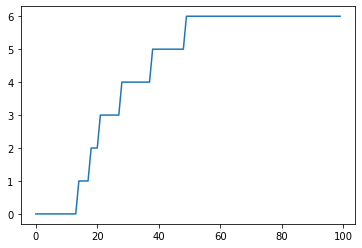

In [21]:
plt.plot(range(len(good_count)), good_count)
plt.show()

In [ ]:
m = nn.Linear(5, 3)
input = torch.randn(1, 5)
output = m(input)
print(input)
print(output)
print(output.size())


In [ ]:
action = select_action(state)
print(action.item())

In [ ]:
test_net = DQNAgent(8)
x = nn.Flatten(to_tensor(state))
print(x)
x = hidden2(x)
print(x)

NameError: name 'plot_durations' is not defined